# KC model demo for 3D modeling


This notebook demonstrates the python code for the SSC model and fit of the Kennel & Coroniti MHD model for the Crab nebula.

In [50]:
import sys
sys.path.append("/Users/manuelmeyer/Python/crabmeyerpy/")
sys.path.append("/Users/manuelmeyer/Python/fast_interp/")

In [51]:
from crabmeyerpy.ssc import kpc2cm, m_e_eV, arcmin2rad, eV2erg, eV2Hz, CrabSSC
from crabmeyerpy.ssc_3d import CrabSSC3D
from crabmeyerpy.electrondensity import nel_crab, nel_crab_extension, nel_crab_radio, nel_crab_radio_cutoff
from crabmeyerpy.electrondensity import gamma_max_kc, nel_wind_kc, B_kc, vz_sq
from crabmeyerpy.photonfields import black_body
from crabmeyerpy.data import CrabData
from scipy.integrate import simps
import matplotlib.pyplot as plt
import numpy as np
import logging
import copy
import astropy.constants as c
import astropy.units as u
import time
from astropy import constants

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load 1D model

For comparison purposes we initialize the 1D model.

In [53]:
# the config for the 1D model
config_1d = {
    # electron spectrum parameters
    "params_n_el": {
        "Nradio": np.exp(120.),
        "gradio_min": np.exp(3.1),
        "gradio_max": np.exp(12.1),
        "Sradio": -1.60,
        "Nwind": np.exp(78.6),
        "gmin": np.exp(3.1),
        "gmax": np.exp(30.),
        "gwind_min": np.exp(12.96),
        "gwind_max": np.exp(22.51),
        "gwind_b": 1. / np.exp(19.5),
        "Swind": -3.23,
        "Sbreak": -0.53, 
        "sup_wind": 2.8,
    },
    # seed photon field parameters
    "params_n_seed": {
        "dust_T": 97.6,
        "dust_norm": 1.06e-13 / 8.11e-06,  # for new dust function
        "dust_extension": 1.3,
        "ic_sync": True, 
        "ic_dust": True,
        "ic_cmb": True
    }
}

In [54]:
#The magnetic field strength and the distance to the nebula
B = 124e-6  # B Field in G
d = 2.  # distance to nebula in kpc

In [55]:
# intitialize the model
ssc_1d = CrabSSC(copy.deepcopy(config_1d), nel_crab, B=B, d=d)

In [56]:
# compute the sync, dust, and IC components
# synchtron and dust component
nu_s_1d = np.logspace(7.,25.,200)  # Frequency in Hz
F_nu_sync_1d = ssc_1d.sync(nu_s_1d)
F_nu_dust_1d = ssc_1d.grey_body(nu_s_1d)

# IC component
nu_ic_1d = np.logspace(20.,30.,100)  # Frequency in Hz
F_nu_IC_1d = ssc_1d.ic(nu_ic_1d, g_steps=100, e_steps=50)

/Users/manuelmeyer/Python/crabmeyerpy/crabmeyerpy/photonfields.py:22: RuntimeWarning: overflow encountered in exp
  result = np.exp(kx) - 1.


Text(0, 0.5, '$\\nu L_\\nu\\,(\\mathrm{erg}\\,\\mathrm{s}^{-1}$)')

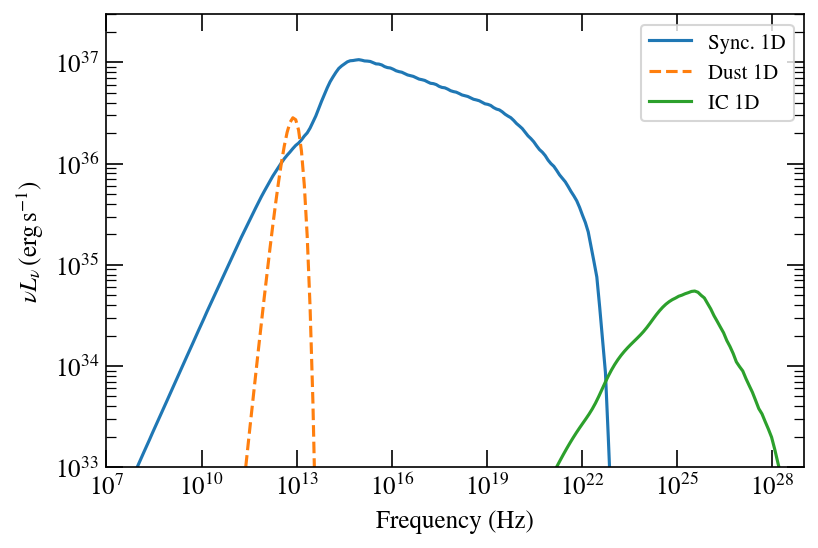

In [57]:
# plot function to plot 1d model output
def plot_1d(luminosity=True, ic=True, sync=True, dust=True, dpi=150, fig=None):
    if fig is None:
        plt.figure(dpi=dpi)
    if luminosity:
        c = 4. * np.pi * (d * kpc2cm)**2
    else:
        c = 1.

    if sync:
        plt.loglog(nu_s_1d, F_nu_sync_1d * nu_s_1d * c, ls='-', label="Sync. 1D")
    if dust:
        plt.loglog(nu_s_1d, F_nu_dust_1d * nu_s_1d * c, ls='--', label="Dust 1D")
    if ic:
        plt.loglog(nu_ic_1d, F_nu_IC_1d * nu_ic_1d * c, ls='-', label="IC 1D")

plot_1d()
plt.gca().set_ylim(1e33,3e37)
plt.gca().set_xlim(1e7,1e29)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu L_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}$)")

# 3D KC model

Next we initialize the 3D model

In [85]:
config = {
    # electron spectrum parameters
    "params_n_el": {
        "sigma": 0.0045,
        "r_shock": 0.14 * u.pc.to('cm'),
        "spin_down_lumi": 5.e38,
        "Nradio": np.exp(-11.41), # these are just some scalings
        "gradio_min": np.exp(0.),
        "gradio_max": np.exp(13.55),
        "Sradio": -1.58,
        "Nwind": np.exp(-1.32), 
        "gwind_min": np.exp(13.94),
        "gwind_max": np.exp(22.60),
        "gmin": np.exp(0.),
        "gmax": np.exp(25.),
        "Swind": -2.32,
    },
    # seed photon field parameters
    "params_n_seed": {
        "dust_T": 97.6,
        "dust_norm": 1.0e-11  / (0.001 * kpc2cm)**3 / 4. / np.pi,  # for new dust function
        "dust_extension": 1.3,  # extension of nebula in FIR from dust
        "ic_sync": True, 
        "ic_dust": True,
        "ic_cmb": True
    },
}

# these would have to be linked in a fit
config['params_B'] = {'sigma': config['params_n_el']['sigma'], 
                      'r_shock': config['params_n_el']['r_shock'],
                      'spin_down_lumi': config['params_n_el']['spin_down_lumi']
                     }

print("E* : {0:.3e} GeV".format(config['params_n_el']['gradio_max'] * m_e_eV / 1e9))
print("E0 : {0:.3e} GeV".format(config['params_n_el']['gwind_min'] * m_e_eV / 1e9))
print("E_cut : {0:.3e} PeV".format(config['params_n_el']['gwind_max'] * m_e_eV / 1e15))

E* : 3.918e+02 GeV
E0 : 5.787e+02 GeV
E_cut : 3.338e+00 PeV


In [86]:
# maximum radius of nebule
r0_pc = 1.8

In [87]:
# the assumed electron spectrum
def n_el_spec(gamma, r, **params):
    return nel_crab_radio_cutoff(gamma, **params) + nel_wind_kc(gamma, r, **params)

In [88]:
ssc = CrabSSC3D(copy.deepcopy(config), n_el_spec, B_kc, d_kpc=d, r0_pc=r0_pc, log_level="DEBUG")

## plot the electron density at different radii

In [89]:
r = np.linspace(ssc.params_n_el['r_shock'], ssc.r0, 21)
r_int = np.linspace(ssc.params_n_el['r_shock'], ssc.r0, 100)
gamma = np.logspace(0., 10., 200)
gamma_int = np.logspace(0., 10., 300)

gg, rr = np.meshgrid(gamma, r, indexing='ij')
gg_int, rr_int = np.meshgrid(gamma_int, r_int, indexing='ij')

zz = rr / ssc.params_n_el['r_shock']
gm = gamma_max_kc(zz, **ssc.params_n_el)
vzz = vz_sq(zz, ssc.params_n_el['sigma'])

g_prime = gg * np.power(vzz, 1. / 3.) / (1. - gg / gm)

Text(0, 0.5, '$ mc^2 \\gamma^2 dn/d\\gamma $ (eV cm$^{-3}$)')

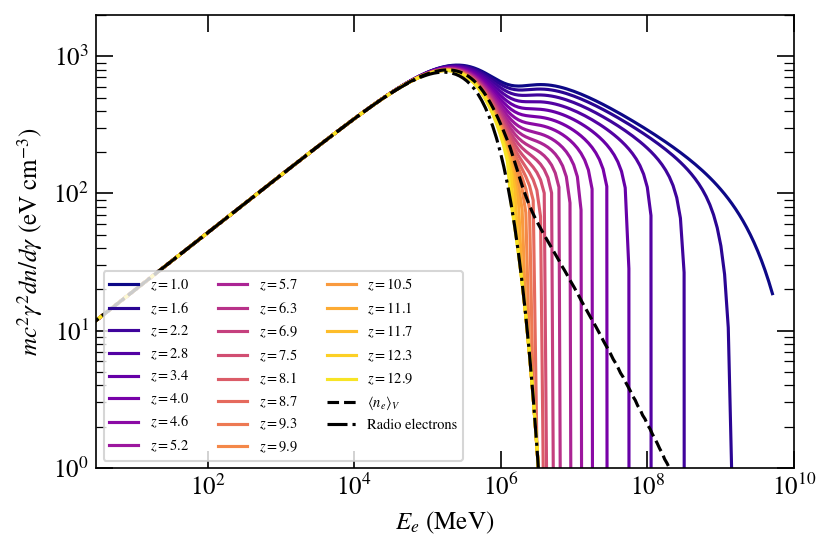

In [90]:
plt.figure(dpi=150)

c = gamma**2. * m_e_eV
c_int = gamma_int**2. * m_e_eV

# compute n_el over grid of gamma and r
n_el = ssc.n_el(gg, rr, **ssc.params_n_el)
n_el_int = ssc.n_el(gg_int, rr_int, **ssc.params_n_el)

# compute volume averaged n_el
V0 = 4. / 3. * np.pi * ssc.r0 ** 3.
n_el_avg = 4. * np.pi * simps(n_el_int * rr_int ** 2., rr_int) / V0

for i, ri in enumerate(r):
    plt.loglog(gamma * m_e_eV / 1e6, n_el[:,i] * c,
               color=plt.cm.plasma(i/r.size),
               label='$z={0:.1f}$'.format(ri / ssc.params_n_el['r_shock'])
              )

# volume averaged
plt.loglog(gamma_int * m_e_eV / 1e6, n_el_avg * c_int, ls='--', color='k',  label=r'$\langle n_e \rangle_V$')

# radio electrons
plt.loglog(gamma * m_e_eV / 1e6,
           nel_crab_radio_cutoff(gamma, **ssc.params_n_el) * c,
           ls='-.', color='k',  label=r'Radio electrons')

plt.legend(fontsize='x-small', ncol=3, loc=3)
v = plt.gca().get_ylim()
plt.ylim(1., 2e3)
plt.xlim(3.e0,1e10)
plt.xlabel("$E_e$ (MeV)")
plt.ylabel("$ mc^2 \gamma^2 dn/d\gamma $ (eV cm$^{-3}$)")

Text(0.5, 0, '$z = r/r_s$')

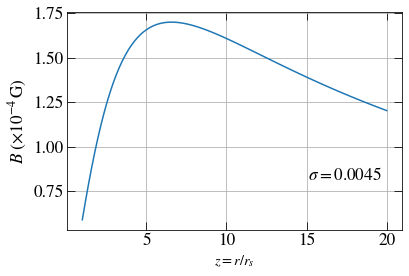

In [91]:
z = np.linspace(1.,20.,100)
plt.plot(z, B_kc(z * ssc.params_B['r_shock'], **ssc.params_B) * 1e4)
plt.annotate(r"$\sigma = {0:.4f}$".format(ssc.params_B['sigma']),
             xy=(0.72, 0.23), xycoords='axes fraction',
             fontsize='xx-large'
            )
plt.grid()
plt.gca().tick_params(labelsize='xx-large')
plt.ylabel(r"$B~(\times 10^{-4}\,\mathrm{G})$", fontsize='xx-large')
plt.xlabel(r"$z = r/r_s$", fontsize='x-large')


## Calculate the Synchrotron and Dust emissivities

Cacluate the volume emissivity $j_\nu^\mathrm{sync}(\nu, r)$ in units of $\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-3}\,\mathrm{sr}^{-1}$.
From it, you can calculate the the luminosity as a volume integral, as well as the specific intensity as a l.o.s. integral. 
From the specific intensity, you get the flux by integrating over solid angle.

In [92]:
nu = np.logspace(7.,25.,300)
nn, rr = np.meshgrid(nu, r, indexing='ij')

In [93]:
j_nu_sync = ssc.j_sync(nu, r, g_axis=2, g_steps=151)
print(j_nu_sync.shape)

(300, 21)


Cacluate the volume emissivity $j_\nu^\mathrm{dust}(\nu, r)$ in units of $\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-3}\,\mathrm{sr}^{-1}$

In [94]:
j_nu_dust = ssc.j_grey_body(nu, r)
print(j_nu_dust.shape)

/Users/manuelmeyer/Python/crabmeyerpy/crabmeyerpy/photonfields.py:22: RuntimeWarning: overflow encountered in exp
  result = np.exp(kx) - 1.
 ssc_3d.py: 446 --- DEBUG: Black body calculation in grey body function took 0.001s
 ssc_3d.py: 477 --- DEBUG: extension calculation in grey body function took 0.000s


(300, 21)


Plot the volume emissivity

(1e-27, 1e-17)

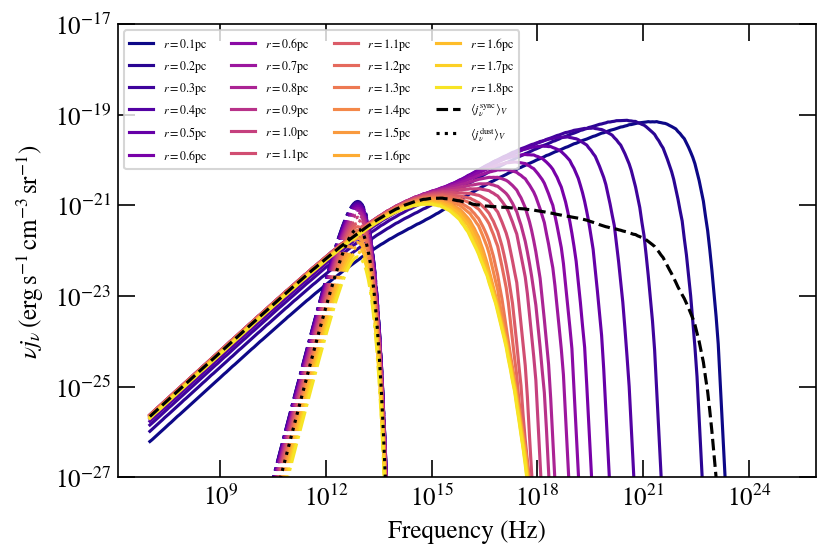

In [95]:
plt.figure(dpi=150)

for i, ri in enumerate(r):
    plt.loglog(nu, j_nu_sync[:,i] * nu,
               color=plt.cm.plasma(i/r.size),
               label='$r={0:.1f}$pc'.format(ri / kpc2cm * 1e3)
              )
    plt.loglog(nu, j_nu_dust[:,i] * nu,
               color=plt.cm.plasma(i/r.size),
               ls='-.'
              )
    
# compute volume averaged n_el
V0 = 4. / 3. * np.pi * ssc.r0 ** 3.
j_nu_sync_avg = 4. * np.pi * simps(j_nu_sync * rr ** 2., rr) / V0
j_nu_dust_avg = 4. * np.pi * simps(j_nu_dust * rr ** 2., rr) / V0

plt.loglog(nu, j_nu_sync_avg * nu,
           color='k',
           ls='--',
           label=r'$\langle j_\nu^\mathrm{sync} \rangle_V$'
           )

plt.loglog(nu, j_nu_dust_avg * nu,
           color='k',
           ls=':',
           label=r'$\langle j_\nu^\mathrm{dust} \rangle_V$'
           )

plt.legend(fontsize='xx-small', ncol=4, loc=2)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu j_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-3}\,\mathrm{sr}^{-1}$)")
plt.ylim(1e-27, 1e-17)

Calculate and plot the luminosity

In [96]:
# one factor of 4 pi from volume integral, second one from integral over 
# the solid angle. Each volume element emits isotropically.
L_nu_sync = simps(j_nu_sync * rr **2., rr, axis=1) * 4. * np.pi * 4. * np.pi
L_nu_dust = simps(j_nu_dust * rr **2., rr, axis=1) * 4. * np.pi * 4. * np.pi

(1e+33, 1e+38)

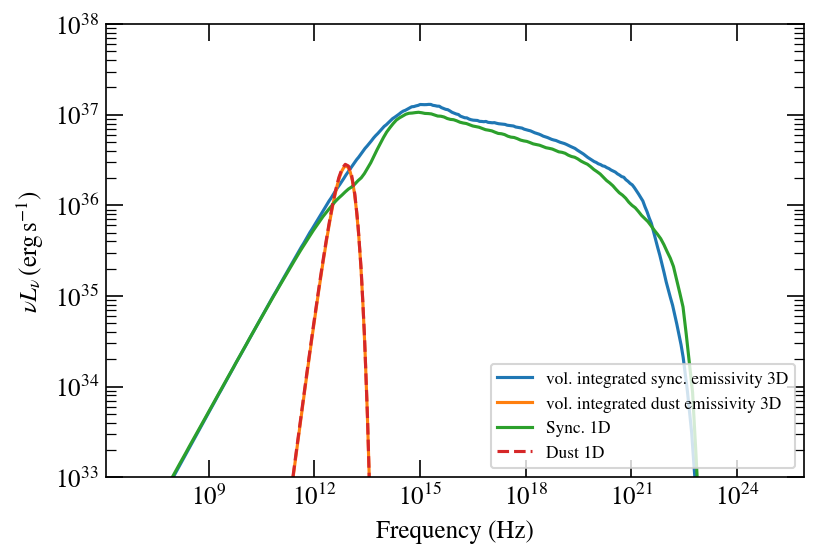

In [97]:
fig = plt.figure(dpi=150)
plt.loglog(nu, nu * L_nu_sync, label="vol. integrated sync. emissivity 3D")
plt.loglog(nu, nu * L_nu_dust, label="vol. integrated dust emissivity 3D")

# plot the 1D spectrum for comparison
plot_1d(fig=fig, ic=False)
plt.legend(fontsize='small')
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu L_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}$)")
plt.ylim(1e33, 1e38)

### Calculate the spectral intensity and flux

From radiation transport and neglecting absorption, the spectral intensity is given by the integral

$$ I_\nu(\theta) = \int_0^{s_\max} j_\nu(s) ds, $$ 

which depends on $\theta$, the angular separation between the nebula center and the line of sight.
To compute it efficiently, we first interpolate the synchrotron volume emissivity.

#### Flux calculation

Once we have obtained $ I_\nu(\theta) $, we can calulate the flux $F_\nu$ that is emitted into a solid angle $\Omega$ 
from a point on the surface of the nebula. This follows the standard calculation of, e.g., calculating the received flux from a resolved stellar disk, i.e., the flux emitted into $[0, \theta]$ is

$$F_\nu = \int I_\nu \cos\theta d\Omega = 2\pi\int_0^\theta I_\nu\cos\theta'\sin\theta' d\theta' $$

In [98]:
ssc.use_fast_interp = True  # use a 2D interpolation routine using numba
ssc.interp_sync_init(r_min=r.min(), r_max=r.max(), nu_steps=300)

In [105]:
I_nu_sync, theta_arcmin, _ = ssc.intensity(nu, theta=100, r_min=ssc.params_n_el['r_shock'])

In [108]:
I_nu_dust, _, _ = ssc.intensity(nu, theta=100, which='dust')

 ssc_3d.py: 446 --- DEBUG: Black body calculation in grey body function took 0.036s
 ssc_3d.py: 477 --- DEBUG: extension calculation in grey body function took 0.045s


Text(0, 0.5, '$\\nu I_\\nu\\,(\\mathrm{erg}\\,\\mathrm{s}^{-1}\\,\\mathrm{cm}^{-2}\\,\\mathrm{sr}^{-1}$)')

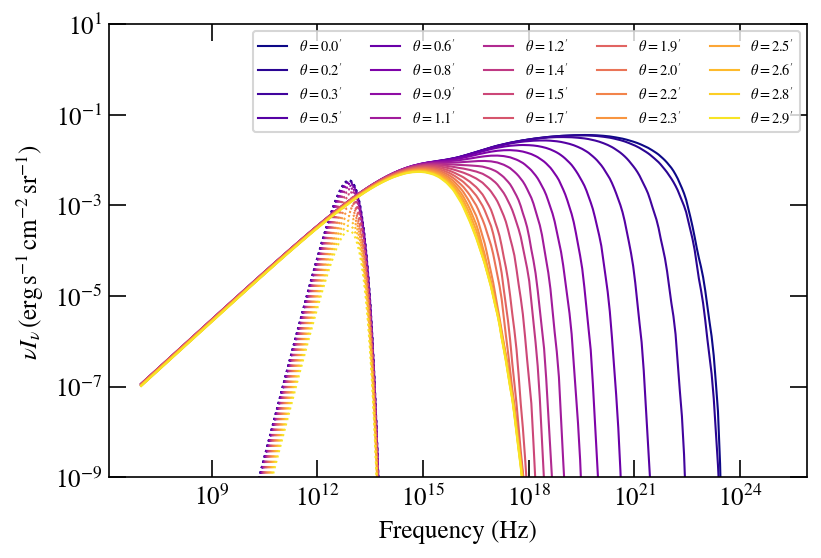

In [111]:
plt.figure(dpi=150)

for i, t in enumerate(theta_arcmin):
    if i % 5:
        continue
    plt.loglog(nu, I_nu_sync[:,i] * nu,
               color=plt.cm.plasma(i / float(theta_arcmin.size)),
               label=r"$\theta={0:.1f}^\prime$".format(t),
               lw=1
              )
    
    plt.loglog(nu, I_nu_dust[:,i] * nu,
               color=plt.cm.plasma(i / float(theta_arcmin.size)),
               #label=r"$\theta={0:.1f}^\prime$".format(t)
               ls=':', lw=1
              )
    
plt.legend(ncol=5, fontsize='x-small')
plt.ylim(1e-9, 1e1)

plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu I_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{sr}^{-1}$)")

Text(0, 0.5, '$I_\\nu / I_\\nu(\\theta = 0^\\circ)$')

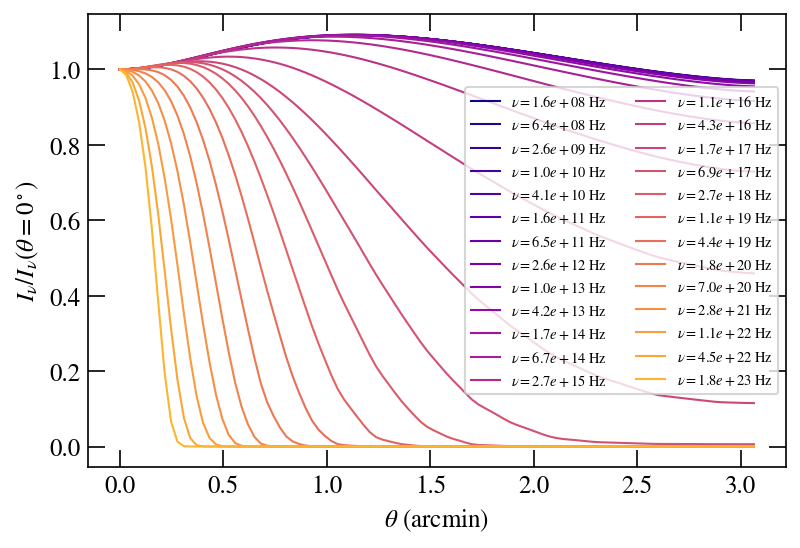

In [113]:
# intensity form factor for different frequencies

plt.figure(dpi=150)
for i, n in enumerate(nu[20:-20]):
    if i % 10:
        continue
        
    plt.plot(theta_arcmin, I_nu_sync[i, :] / I_nu_sync[i, 0],
               color=plt.cm.plasma(i / float(nu.size)),
               label=r"$\nu={0:.1e}$ Hz".format(n),
               lw=1
            )
    
plt.legend(ncol=2, fontsize='x-small', loc='center right')
plt.xlabel(r"$\theta$ (arcmin)")
plt.ylabel(r"$I_\nu / I_\nu(\theta = 0^\circ)$")

Text(0, 0.5, '$\\nu F_\\nu\\,(\\mathrm{erg}\\,\\mathrm{s}^{-1}\\,\\mathrm{cm}^{-2}$)')

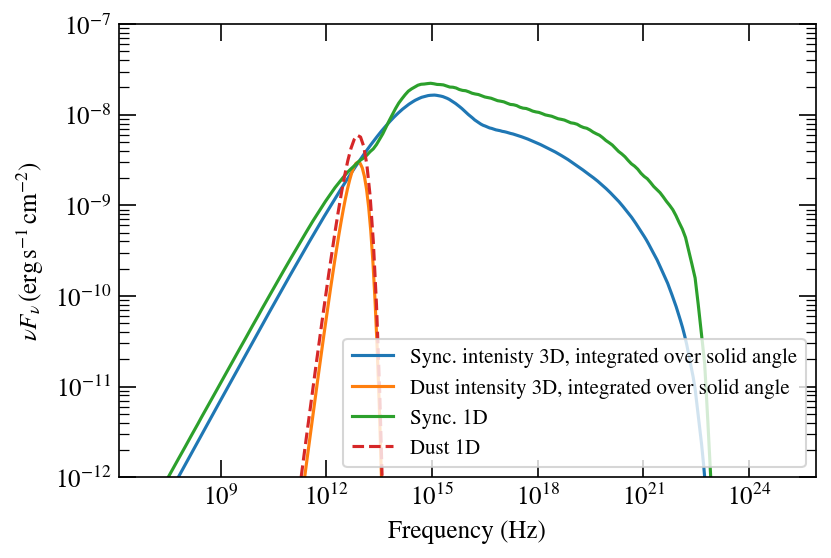

In [114]:
# plot and calculate the flux received from the whole projection of the nebula on the sky
fig=plt.figure(dpi=150)

nn, tt = np.meshgrid(nu, theta_arcmin, indexing='ij')

# synchrotron flux
f_nu_sync = 2. * np.pi * simps(I_nu_sync * np.cos(tt * arcmin2rad) * np.sin(tt * arcmin2rad),
                               tt * arcmin2rad, axis=1)

# dust flux
f_nu_dust = 2. * np.pi * simps(I_nu_dust * np.cos(tt * arcmin2rad) * np.sin(tt * arcmin2rad),
                               tt * arcmin2rad, axis=1)



plt.loglog(nu, f_nu_sync * nu, label="Sync. intenisty 3D, integrated over solid angle")
plt.loglog(nu, f_nu_dust * nu, label="Dust intensity 3D, integrated over solid angle")
plt.ylim(1e-12, 1e-7)

plot_1d(luminosity=False, fig=fig, ic=False)

plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu F_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}$)")

## IC component

Now we repeat the steps of calculating $j_\nu$, $I_\nu$, and $F_\nu$ for the IC component. Since this takes considerably longer as it involves three integrals, we use a much coarser grid for $\nu$ and $r$.  

In [115]:
# define nu and r arrays 
nu_ic = np.logspace(22., 29., 40)
r_ic_egdes = np.linspace(ssc.params_n_el['r_shock'], ssc.r0, 20)
r_ic = 0.5 * (r_ic_egdes[1:] + r_ic_egdes[:-1])

nni, rri = np.meshgrid(nu_ic, r_ic, indexing='ij')

# set the steps used for the integration
# these numbers yielded relatively smooth spectra
# in my tests 
g_steps = 82  # steps for integration over gamma
e_steps = 74  # steps for integration over energy of seed photon field
r1_steps = 22   # steps for integration over radius, see Atoyan & Aharonian (1996) Eq. 15

In [116]:
ssc.integration_mode = "numba_piecewise"  # fastest mode of integration
ssc.use_fast_interp = True  # fastest mode of interpolation

t0 = time.time()
j_nu_ic = ssc.j_ic(nu_ic, r_ic,
                   g_steps=g_steps,
                   e_steps=e_steps,
                   r1_steps=r1_steps)
t1 = time.time()

print(f"This took {t1 - t0:.2f}s")

 ssc_3d.py: 568 --- DEBUG: (40, 82, 74, 19, 22)
 ssc_3d.py: 569 --- DEBUG: Integrating using numba_piecewise
 ssc_3d.py: 446 --- DEBUG: Black body calculation in grey body function took 3.115s
 ssc_3d.py: 477 --- DEBUG: extension calculation in grey body function took 3.193s
 ssc_3d.py: 594 --- DEBUG: time to calculate grey body 10.215s  time for integration of dust component  6.735s
 ssc_3d.py: 597 --- DEBUG: phot_dens: time for interpolation of Sync: 13.469s, time for integration of SSC component  11.772s,  time for filling arrays 3.360s 
/Users/manuelmeyer/Python/crabmeyerpy/crabmeyerpy/photonfields.py:22: RuntimeWarning: overflow encountered in exp
  result = np.exp(kx) - 1.
 ssc_3d.py: 674 --- DEBUG: kernel shape for integration over photon dens energy: (40, 82, 74, 19)
 ssc_3d.py: 679 --- DEBUG: kernel shape for integration over gamma factor: (40, 82, 19)
 ssc_3d.py: 693 --- DEBUG: integration over photon dens and gamma took 2.342s


This took 49.19s


In [117]:
j_nu_ic_interp = np.exp(ssc._j_ic_interp(np.log(nni), rri, grid=False))

(1e-27, 1e-22)

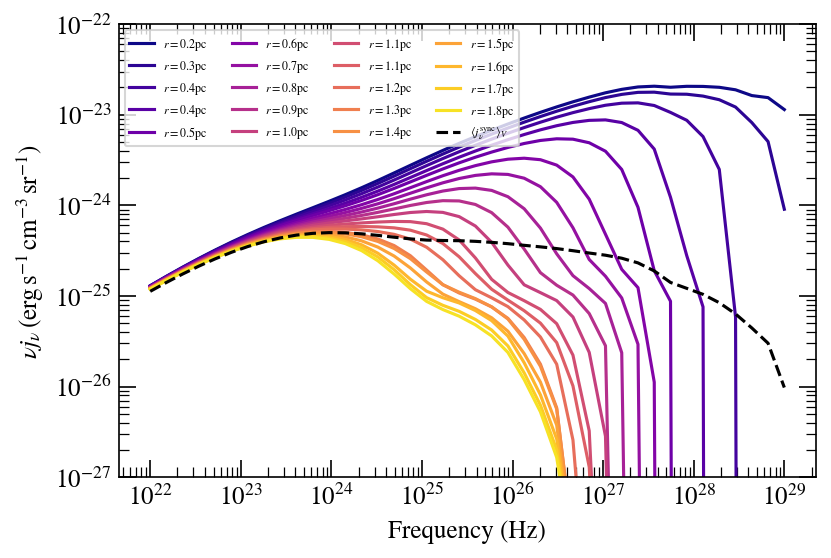

In [123]:
plt.figure(dpi=150)

for i, ri in enumerate(r_ic):
    plt.loglog(nu_ic, j_nu_ic[:,i] * nu_ic,
               color=plt.cm.plasma(i/r_ic.size),
               label='$r={0:.1f}$pc'.format(ri / kpc2cm * 1e3)
              )
    #plt.loglog(nu_ic, j_nu_ic_interp[:,i] * nu_ic,
    #           color='k',
    #           ls=':',
    #          )
    
# compute volume averaged n_el
V0 = 4. / 3. * np.pi * ssc.r0 ** 3.
j_nu_ic_avg = 4. * np.pi * simps(j_nu_ic * rri ** 2., rri) / V0

plt.loglog(nu_ic, j_nu_ic_avg * nu_ic,
           color='k',
           ls='--',
           label=r'$\langle j_\nu^\mathrm{sync} \rangle_V$'
           )

plt.legend(fontsize='xx-small', ncol=4, loc=2)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu j_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-3}\,\mathrm{sr}^{-1}$)")
plt.ylim(1e-27, 1e-22)

In [119]:
# Calculate the luminosity
# one factor of 4 pi from volume integral, second one from integral over 
# the solid angle. Each volume element emits isotropically.
L_nu_ic = simps(j_nu_ic * rri **2., rri, axis=1) * 4. * np.pi * 4. * np.pi

(1e+30, 1e+35)

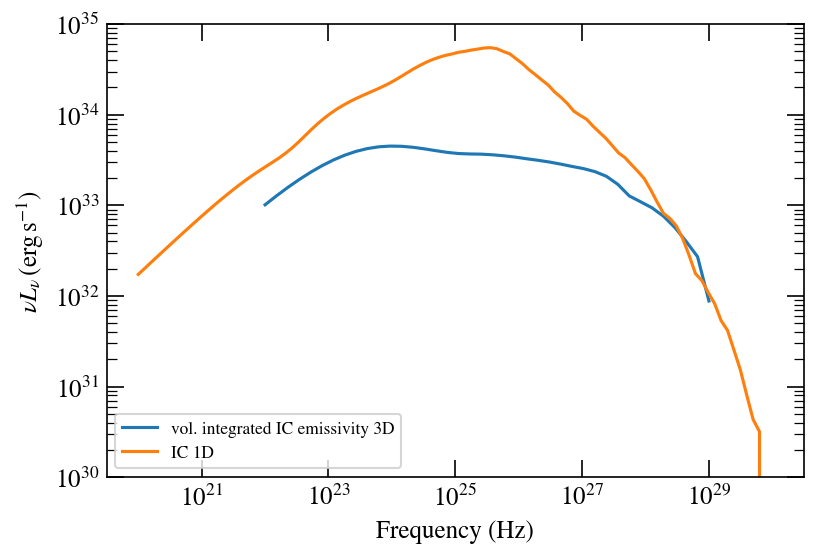

In [120]:
fig = plt.figure(dpi=150)
plt.loglog(nu_ic, nu_ic * L_nu_ic, label="vol. integrated IC emissivity 3D")

# plot the 1D spectrum for comparison
plot_1d(fig=fig, ic=True, sync=False, dust=False)
plt.legend(fontsize='small')
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu L_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}$)")
plt.ylim(1e30, 1e35)

In [121]:
I_nu_ic, theta_arcmin_ic, j = ssc.intensity(nu_ic, theta=20,
                                            r_min=ssc.params_n_el['r_shock'],
                                            r_steps=500,
                                            log=True,
                                            which='ic')

(1e-27, 1e-22)

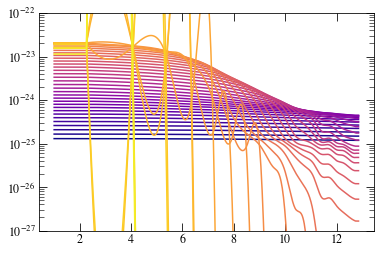

In [122]:
r_intens = np.linspace(ssc.params_n_el['r_shock'], ssc.r0, 500)
for i, n in enumerate(nu_ic):
    plt.semilogy(r_intens / ssc.params_n_el['r_shock'],
                 j[i,0] * n, color=plt.cm.plasma(i / nu_ic.size))
    
plt.ylim(1e-38, 1e-4)

plt.ylim(1e-27, 1e-22)

Text(0, 0.5, '$\\nu I_\\nu\\,(\\mathrm{erg}\\,\\mathrm{s}^{-1}\\,\\mathrm{cm}^{-2}\\,\\mathrm{sr}^{-1}$)')

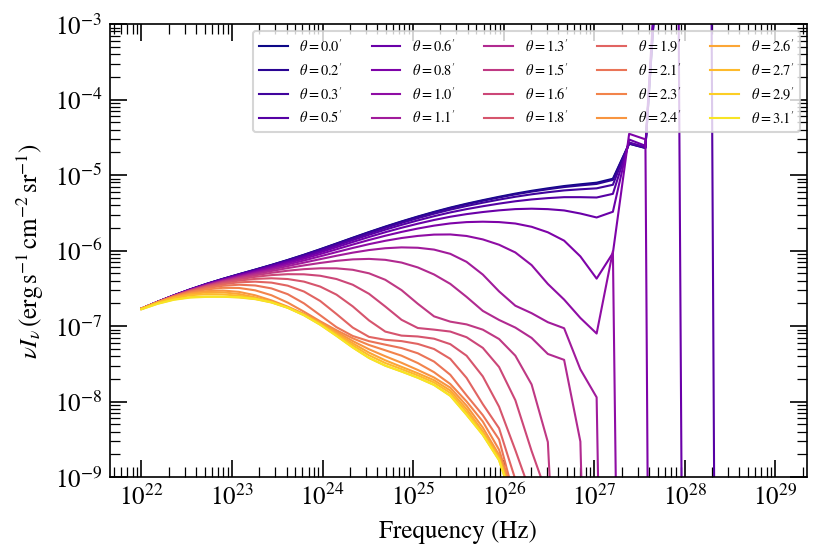

In [36]:
plt.figure(dpi=150)

for i, t in enumerate(theta_arcmin_ic):
    plt.loglog(nu_ic, I_nu_ic[:,i] * nu_ic,
               color=plt.cm.plasma(i / float(theta_arcmin_ic.size)),
               label=r"$\theta={0:.1f}^\prime$".format(t),
               lw=1
              )

    
plt.legend(ncol=5, fontsize='x-small')
plt.ylim(1e-9, 1e-3)

plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu I_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{sr}^{-1}$)")

Text(0, 0.5, '$\\theta^2I_\\nu / I_\\nu(\\theta = 0^\\circ)$')

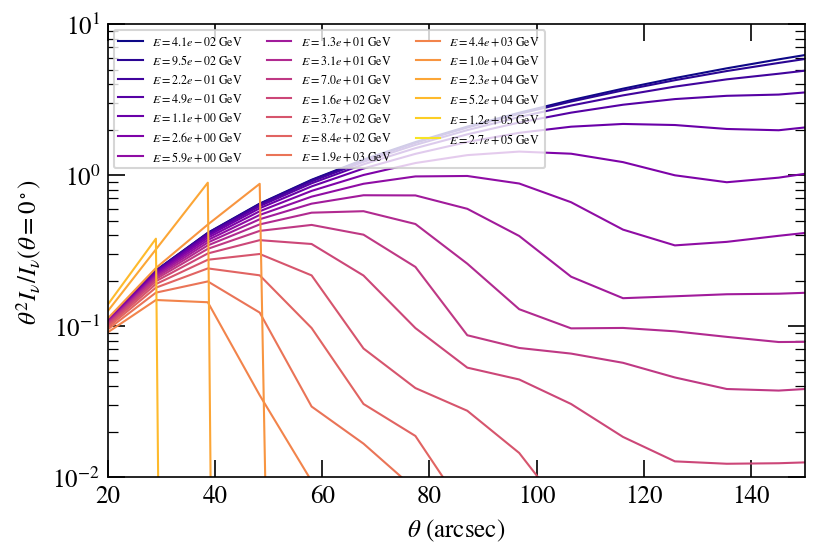

In [223]:
# intensity form factor for different frequencies

plt.figure(dpi=150)
for i, n in enumerate(nu_ic):
    if i % 2:
        continue
        
    plt.plot(theta_arcmin_ic * 60., theta_arcmin_ic**2. * I_nu_ic[i, :] / I_nu_ic[i, 0],
               color=plt.cm.plasma(i / float(nu_ic.size)),
               label=r"$E={0:.1e}$ GeV".format(n * constants.h.value * u.J.to('GeV')),
               lw=1
            )
    
plt.ylim(1e-2, 1e1)
plt.xlim(20, 150)
plt.yscale('log')
plt.legend(ncol=3, fontsize='xx-small', loc=2)
plt.xlabel(r"$\theta$ (arcsec)")
plt.ylabel(r"$\theta^2I_\nu / I_\nu(\theta = 0^\circ)$")

## Full SED pass

Here, we time how long it takes to calculate the whole SED for one set of parameters.

In [36]:
%%timeit

# define r and nu arrays
r = np.linspace(0., ssc.r0, 10)
nu_sync = np.logspace(7.,25.,200)

# Calculate and interpolate the synchrotron spectrum
ssc.use_fast_interp = True  # use a 2D interpolation routine using numba
ssc.interp_sync_init(r_min=r.min(), r_max=r.max())

# Calculate the intensities along the line of sight
I_nu_sync, theta_arcmin = ssc.intensity(nu, theta=20)
I_nu_dust, _ = ssc.intensity(nu, theta=20, which='dust')

# Calculate the IC emissivity
nu_ic = np.logspace(20., 28., 32)
r_ic_egdes = np.linspace(0., ssc.r0, 20)
r_ic = 0.5 * (r_ic_egdes[1:] + r_ic_egdes[:-1])

g_steps = 72  # steps for integration over gamma
e_steps = 74  # steps for integration over energy of seed photon field
r1_steps = 22   # steps for integration over radius, see Atoyan & Aharonian (1996) Eq. 15

ssc.integration_mode = 'numba_piecewise'  # fastest option
ssc.use_fast_interp = True  # fastest mode of interpolation

j_nu_ic = ssc.j_ic(nu_ic, r_ic,
                   g_steps=g_steps,
                   e_steps=e_steps,
                   r1_steps=r1_steps)

# calculate the intensity along the line of sight
I_nu_ic, theta_arcmin_ic = ssc.intensity(nu_ic, theta=20, which='ic')

/Users/manuelmeyer/Python/crabmeyerpy/crabmeyerpy/ssc_3d.py:332: RuntimeWarning: divide by zero encountered in true_divide
  x = nnn / nu_c
/Users/manuelmeyer/Python/crabmeyerpy/crabmeyerpy/ssc_3d.py:401: RuntimeWarning: divide by zero encountered in log
  log(j_sync),
/Users/manuelmeyer/Python/fast_interp/fast_interp/fast_interp.py:15: RuntimeWarning: invalid value encountered in subtract
  f[il] = 4*f[il+1] - 6*f[il+2] + 4*f[il+3] - f[il+4]
/Users/manuelmeyer/Python/fast_interp/fast_interp/fast_interp.py:16: RuntimeWarning: invalid value encountered in subtract
  f[ih] = 4*f[ih-1] - 6*f[ih-2] + 4*f[ih-3] - f[ih-4]
 ssc_3d.py: 446 --- DEBUG: Black body calculation in grey body function took 0.004s
 ssc_3d.py: 477 --- DEBUG: extension calculation in grey body function took 0.005s
 ssc_3d.py: 565 --- DEBUG: (32, 72, 74, 19, 22)
 ssc_3d.py: 566 --- DEBUG: Integrating using numba_piecewise
 ssc_3d.py: 446 --- DEBUG: Black body calculation in grey body function took 1.334s
 ssc_3d.py: 477 

35.2 s ± 558 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
